In [2]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
from matplotlib import colors
from brain_block.random_initialize import connect_for_block, connect_for_multi_sparse_block
from brain_block.block import block
from analysis.spike_statistics import *
from scipy.ndimage import gaussian_filter1d
from scipy.io import loadmat
%matplotlib inline


In [2]:
def plot2d(data, xrange, yrange, emphasise_range=None, name="fr"):
    if emphasise_range is None:
        raise ValueError
    else:
        fig= plt.figure(figsize=(8, 5), dpi=100)
        ax = []
        ax.append(fig.add_axes([0.05, 0.1, 0.35, 0.8]))
        ax.append(fig.add_axes([0.5, 0.1, 0.35, 0.8]))
        ax.append(fig.add_axes([0.9, 0.25, 0.02, 0.5]))
    x, y = data.shape
    im = ax[0].imshow(data)  # norm=norm
    data = np.where(np.logical_and(data<=emphasise_range[1], data>=emphasise_range[0]), data, np.nan)
    ax[1].imshow(data)
    fig.colorbar(im, ax=[ax[0], ax[1]], cax=ax[2])
    for i in range(2):
        ax[i].grid(False)
        yticks = np.linspace(0, x, 4, endpoint=False, dtype=np.int8)
        ax[i].set_yticks(yticks)
        ax[i].set_yticklabels([f'{data:.1f}' for data in yrange[yticks]], rotation=60)
        xticks = np.linspace(0, y, 4, endpoint=False, dtype=np.int8)
        ax[i].invert_yaxis()
        ax[i].set_xticks(xticks)
        ax[i].set_xticklabels([f'{data:.1f}' for data in xrange[xticks]], )
    ax[0].set_ylabel(r"$AMPA Contribution$")
    ax[0].set_xlabel(r"$GABA_{A} Contribution$")
    ax[0].set_title(name)
    return fig

def arg_percentile(series, x):
    a, b = 0, 1
    while True:
        # m是a、b的终点
        m = (a+b)/2
        # 可以打印查看求解过程
        # print(np.percentile(series, 100*m), x)
        if np.percentile(series, 100*m) >= x:
            b = m
        elif np.percentile(series, 100*m) < x:
            a = m
        # 如果区间左右端点足够靠近，则退出循环。
        if np.abs(a-b) <= 0.000001:
            break
    return m

def index2param(xrange, yrange, index, *args):
    a, b , c, d = args
    ampa_contribution = xrange[index[0]]
    gabaA_contribution = yrange[index[1]]
    ampa = ampa_contribution / a
    nmda = (1 - ampa_contribution) / b
    gabaA = gabaA_contribution / c
    gabaB = (1 - gabaA_contribution) / d
    param = np.array([ampa, nmda, gabaA, gabaB])
    return param

# Rearrange the experimental steps
* theroem analysis
* estimate parameter
    * two level: strong synaptic current and weak synaptic current
    * OU process approximate to illustrate this theorem
* run grid search for phase diagram
* explore different spike dynamics

Orinignal model which has absorbed some complicated parameter
$ \tau_{j} \dot{V_{j}}  = - \sum_{A=L, E, I}g_{A}^{j}(V_{j} - E_{A})$
where $\dfrac{g_{E, I}^{j}}{g_{L}^{j}}=\tau_{j}\sum_{m} \sum_{k|t_{m}^{k}<t}\int_{-\infty}^{t}dt^{\prime}a_{\tau_{decay}}\left(t - t^{\prime}\right) \delta(t^{\prime}-t_{m}^{k})$, usually, $a_{\tau_{decay}}(t)=e^{-t / \tau_{decay}} / \tau_{decay}$, but here we use the limit that $\tau_{decay} \rightarrow 0$

* excitatory and inhibitory currents must be fine-tuned to produce an average input below threshold.
    * Specifically, if K and J represent the average number of input connections per neuron and synaptic efficacy, respectively, the difference between excitatory and inhibitory presynaptic inputs must be of the order of 1=KJ.
* input fluctuations should be large enough to drive firing.

Under the assumption, we can use the diffusion approximation and approximate the conductances as
\begin{equation}
\begin{aligned}
&\frac{g_{E}}{g_{L}}=a \tau_{L}\left[K r_{E}+\sqrt{K r_{E}} \zeta_{E}\right], \\
&\frac{g_{I}}{g_{L}}=a g \tau_{L}\left[\gamma K r_{I}+\sqrt{\gamma K r_{I}} \zeta_{I}\right]
\end{aligned}
\end{equation}

Using the diffusion approximation, OU process, the CV equation can be reduced to
\begin{equation}
\tau \frac{d V}{d t}=-V+\mu+\sigma(V) \sqrt{\tau} \zeta
\end{equation}
where
\begin{equation}
\begin{aligned}
\tau^{-1} &=\tau_{L}^{-1}+a K\left(r_{E}+r_{I} g \gamma\right) \\
\mu &=\tau\left\{E_{L} / \tau_{L}+a K\left[r_{E} E_{E}+r_{I} g \gamma E_{I}\right]\right\} \\
\sigma^{2}(V) &=a^{2} K \tau\left[r_{E}\left(V-E_{E}\right)^{2}+g^{2} \gamma r_{I}\left(V-E_{I}\right)^{2}\right]
\end{aligned}
\end{equation}

In [ ]:
# ou process
class OrnsteinUhlenbeck:
    def __init__(self,N, L, T, V, r, tmax, dt, x0 = 0, seed=-1):
        self.N = N
        self.L = L
        self.T = T
        self.dt = dt
        self.factor_B = np.sqrt(2*T*self.dt)
        self.tmax = tmax
        self.x0 = x0

        if seed!=-1:
            np.random.seed(seed)

        self.t = np.linspace(0,self.tmax,self.tmax/self.dt+1)
        self.X = np.zeros((len(self.t),self.N))
        self.X[0,:] = x0*np.ones((self.N,))

        self.V = V
        self.r = r

    def simulate(self):
        for t in np.arange(1,len(self.t)):
            self.X[t,:] = self.X[t-1,:] + \
                          self.V*(self.r-self.X[t-1,:]) * self.dt + \
                          self.factor_B * np.random.randn(self.N)
            ndcs_left  = np.nonzero(self.X[t,:]<-self.L/2)[0]
            ndcs_right = np.nonzero(self.X[t,:]>+self.L/2)[0]
            self.X[t,ndcs_left] += self.L
            self.X[t,ndcs_right] -= self.L


    def get_trajectories(self):
        return self.t,self.X

## Single neuron simulation


In [21]:
class lif_neuron:
    """
    lif neuron which conductance-based but no time scale.
    """

    def __init__(self, delta_t=0.1, k=80, gamma=0.25, a=0.01, g=1.2, eta=1., mu_e=0.003, ):
        self.tau = 1 / 0.03
        self.E_e = 0
        self.E_i = -70
        self.voltage_threshold = -50
        self.voltage_reset = -65
        self.voltage_leaky = -75
        self.refractory = 5
        self.delta_t = delta_t
        self.v = (self.voltage_reset + self.voltage_threshold) / 2
        self.k = k
        self.gamma = gamma
        self.a = a  # synaptic efficacy
        self.g = g
        self.mu_e = mu_e
        self.eta = eta
        self._s_e = 0.
        self._s_i = 0.
        self._I_syn_e = 0.
        self._I_syn_i = 0.
        self.t = 0.
        self.t_ik_last = 0.
        self.I_syn = None
        self.active = None

    def evolve(self):
        self.t = self.t + self.delta_t
        active_e = (np.random.rand(self.k) < self.mu_e * self.delta_t)
        active_i = (np.random.rand(int(self.k * self.gamma)) < self.mu_e * self.delta_t * self.eta)
        self._s_e = np.sum(active_e)
        self._s_i = np.sum(active_i)
        self._I_syn_e = - self.tau * self.a * (self.v - self.E_e) * self._s_e
        self._I_syn_i = - self.tau * self.a * self.g * (self.v - self.E_i) * self._s_i
        self.I_syn = self._I_syn_i + self._I_syn_e
        main_part = - (self.v - self.voltage_leaky)
        C_diff_v = main_part + self.I_syn
        delta_v = self.delta_t / self.tau * C_diff_v
        vi_normal = self.v + delta_v
        is_not_saturated = (self.t >= self.t_ik_last + self.refractory)
        self.v = np.where(is_not_saturated, vi_normal, self.voltage_reset)
        self.active = self.v > self.voltage_threshold
        self.t_ik_last = self.t if self.active else self.t_ik_last

    def run(self, t):
        time = int(t / self.delta_t)
        for _ in range(time):
            self.evolve()
            yield self.v, self.active


spike nonzero [  21   66  163  199  240  355  392  470  496  630  861 1013 1107 1367
 1446 1475 1498 1539 1591 1645]


[]

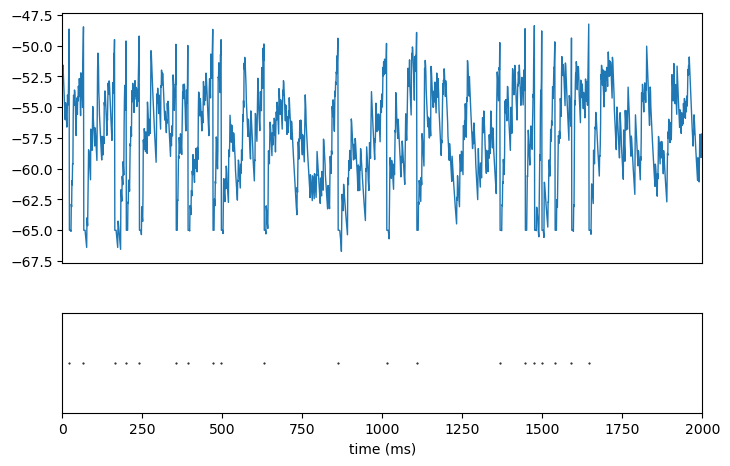

In [34]:
lif = lif_neuron(a=0.4, k=100, gamma=0.25, eta=1, g=1)
spike = []
v = []
time = 3000
for out in lif.run(time):
    spike.append(out[1])
    v.append(out[0])
spike = np.array(spike)
v = np.array(v)
spike = spike.reshape((time, 10))
v = v.reshape((time, 10))
spike = np.sum(spike, axis=1)[1000:]
v = np.max(v, axis=1)[1000:]
fig = plt.figure(figsize=(8, 5), dpi=100)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.2])
spike_nonzero = spike.nonzero()[0]
print("spike nonzero", spike_nonzero)
ax.scatter(spike_nonzero, np.ones_like(spike_nonzero), c="k", marker=".", s=1)
ax.set_ylim([0, 2])
ax.set_yticks([])
ax.set_xlim([0, time-1000])
ax.set_xlabel("time (ms)")
ax = fig.add_axes([0.1, 0.4, 0.8, 0.5])
ax.plot(v, lw=1.)
ax.set_xlim([0, time-1000])
ax.set_xticks([])

### load data (grid search d100)

In [3]:
file = np.load("../data/grid_search_d100.npz")


# phase diagram

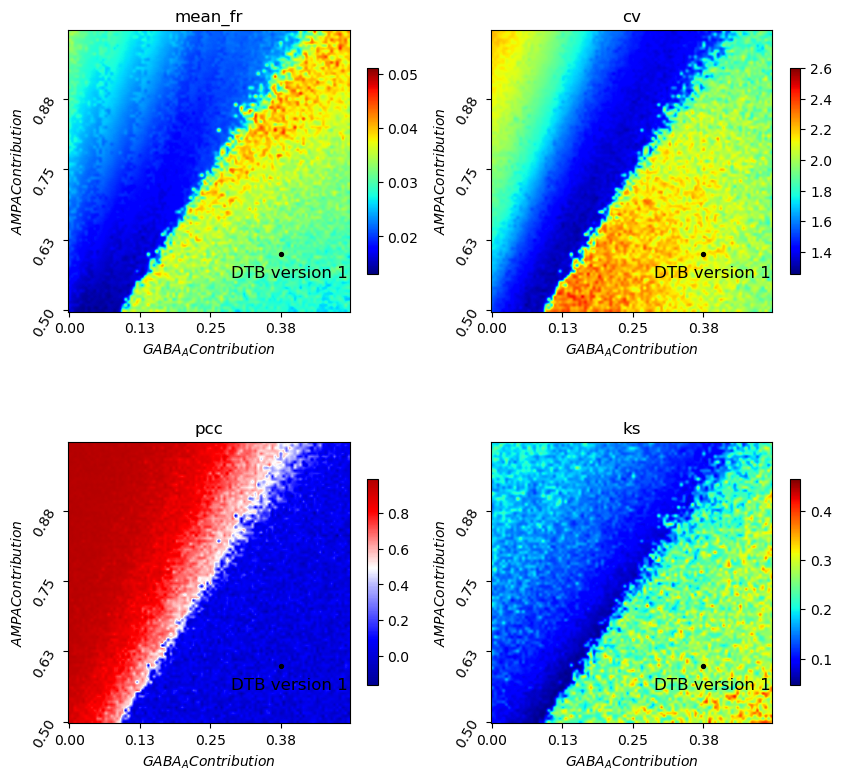

In [4]:
mean_fr = file["mean_fr"]
cv = file["cv"]
pcc = file["pcc"]
ks = file["ks"]
cc = file["cc"]
ampa_contribution = file["ampa_contribution"]
gabaA_contribution = file["gabaA_contribution"]
fig, ax = plt.subplots(2, 2, figsize=(10, 10), dpi=100)
ax = ax.flatten()
x, y = mean_fr.shape

im = ax[0].imshow(mean_fr, cmap='jet', interpolation='gaussian')
fig.colorbar(im, ax=ax[0], shrink=0.6)
ax[0].grid(False)
ax[0].set_title("mean_fr")

im = ax[1].imshow(cv, cmap='jet', interpolation='gaussian')
fig.colorbar(im, ax=ax[1], shrink=0.6)
ax[1].grid(False)
ax[1].set_title("cv")

pcc_data = pcc.flatten()
percent1 = arg_percentile(pcc_data, 0.2)
percent2 = arg_percentile(pcc_data, 0.8)
first = np.round(255*percent1).astype(np.int8)
second = np.round(255*(percent2 - percent1)).astype(np.int8)
third = 256 - first - second
#colors2 = new_cmap(np.linspace(0, 1, first))
colors1 = plt.cm.seismic(np.linspace(0.1, 0.42, first))
# colors2 = np.ones((second, 4), dtype=np.float64)
colors2 = plt.cm.seismic(np.linspace(0.42, 0.58, second))
colors3 = plt.cm.seismic(np.linspace(0.58, 0.9, third))
cols = np.vstack((colors1, colors2,colors3))
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', cols)
im = ax[2].imshow(pcc, interpolation='bilinear', cmap=mymap)
fig.colorbar(im, ax=ax[2], shrink=0.6)
ax[2].grid(False)
ax[2].set_title("pcc")

im = ax[3].imshow(ks, cmap='jet', interpolation='gaussian')
fig.colorbar(im, ax=ax[3], shrink=0.6)
ax[3].grid(False)
ax[3].set_title("ks")


for i in range(4):
    ax[i].scatter([75], [20], marker="o", s=8, color="k")
    ax[i].text(0.58, 0.12, "DTB version 1", fontsize=12, transform=ax[i].transAxes)
    yticks = np.linspace(0, x, 4, endpoint=False, dtype=np.int8)
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels([f'{data:.2f}' for data in ampa_contribution[yticks]], rotation=60)
    xticks = np.linspace(0, y, 4, endpoint=False, dtype=np.int8)
    ax[i].invert_yaxis()
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels([f'{data:.2f}' for data in gabaA_contribution[xticks]], )
    ax[i].set_ylabel(r"$AMPA Contribution$")
    ax[i].set_xlabel(r"$GABA_{A} Contribution$")
# fig.savefig("DTV_version1.png")


# boundary line, i.e, critical regime

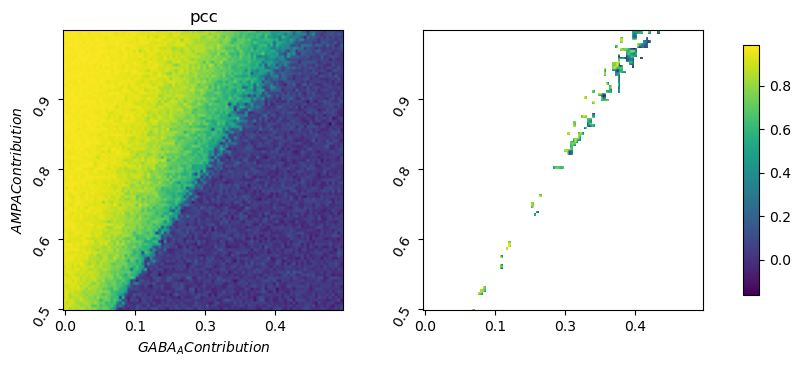

In [14]:
emphasise_range = (0.3, 0.6)
fig = plot2d(pcc, gabaA_contribution, ampa_contribution, emphasise_range, "pcc")


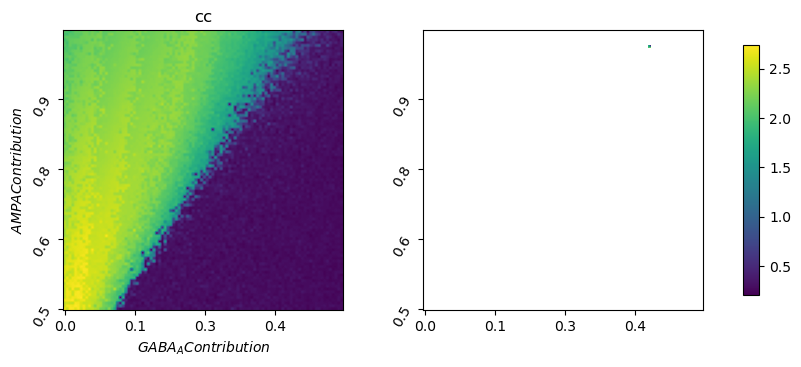

In [25]:
fig = plot2d(cc, gabaA_contribution, ampa_contribution, (0.8, 1.2), "cc")

In [6]:
emphasise_range = (0.8, 1.2)
critical_index = np.where(np.logical_and(cc<=emphasise_range[1], cc>=emphasise_range[0]))
point = 50
print(critical_index[0][point], critical_index[1][point])
print("pcc", pcc[critical_index[0][point], critical_index[1][point]])
print("cc", cc[critical_index[0][point], critical_index[1][point]])
index = (critical_index[0][point], critical_index[1][point])
# for d100 \math
#       34 * ampa + 250 * nmda = 1
#       2 * gabaA + 36 * gabaB = 1
specified_gui = index2param(ampa_contribution,gabaA_contribution, index, 34., 250., 2., 36.)
print("specified_gui:", specified_gui)

59 58
pcc 0.24893583568226743
cc 0.8205105662345886
specified_gui: [0.02346999 0.00080808 0.14646465 0.01964085]


# Run Simulation


torch.Size([2000, 22]) torch.Size([4, 2000, 2000])
log.max 1
cc:  1.5909464
pcc:  0.4972764979594981


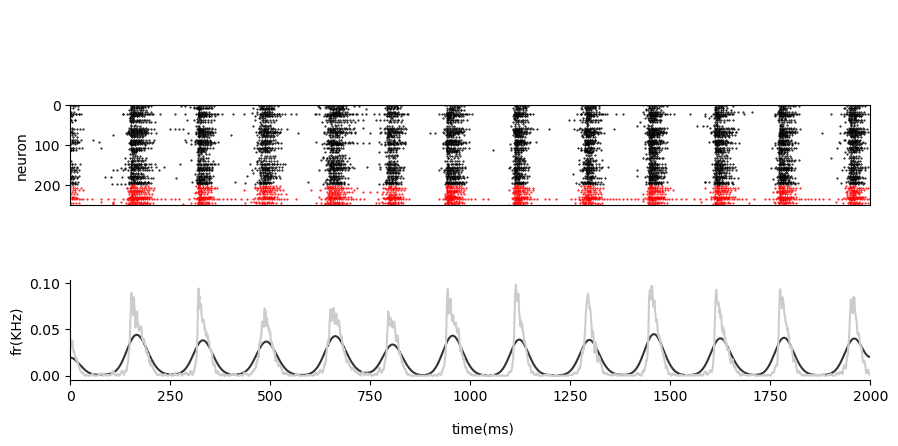

In [7]:
prob = torch.tensor([[1.]])
path = "small_block_d100"
tau_ui = (8, 40, 10, 50)

# if os.path.exists(os.path.join(path, 'single', 'block_0.npz')):
#     print("remove")
#     os.remove(os.path.join(path, 'single', 'block_0.npz'))
# connect_for_multi_sparse_block(prob, {'g_Li': 0.03,
#                                       'g_ui': specified_gui,
#                                       "V_reset": -65,
#                                         'tao_ui': tau_ui},
#                                E_number=int(1.6e3), I_number=int(4e2), degree=100, init_min=0,
#                                init_max=1, perfix=path)
property, w_uij = connect_for_block(os.path.join(path, 'single'))


property[:, 10:14] = torch.tensor(specified_gui)

property = property.cuda()
w_uij = w_uij.cuda()
B = block(
    node_property=property,
    w_uij=w_uij,
    delta_t=0.1,
)
log_all = []
for time in range(30000):
    print(time, end='\r')
    B.run(noise_rate=0.0003, isolated=False)
    if time >= 10000:
        log_all.append(B.active.data.cpu().numpy())
log_all = np.array(log_all, dtype=np.uint8)
log = log_all[:, 1400:1650]
log = log.reshape((-1, 10, 250))
sub_log = log.sum(axis=1)
# np.save(os.path.join(self.path, "log.npy"), sub_log)
print("log.max", sub_log.max())
pcc_log = pearson_cc(sub_log[:, :200], pairs=200)
cc_log = correlation_coefficent(sub_log[:, :200])
print("cc: ", cc_log)
print("pcc: ", pcc_log)
fr = instantaneous_rate(sub_log, bin_width=5)
rate_time_series_auto_kernel = gaussian_filter1d(fr, 20, axis=-1)
fig = plt.figure(figsize=(10, 5), dpi=100)
ax = fig.add_subplot(1, 1, 1, frameon=False)
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.grid(False)
ax.set_xlabel('time(ms)')
ax = fig.add_axes([0.1, 0.35, 0.8, 0.5])
x, y = sub_log[:, :200].nonzero()
ax.scatter(x, y, marker='.', color="black", s=1)
x, y = sub_log[:, 200:].nonzero()
ax.scatter(x, y + 200, marker='.', color="red", s=1)
ax.set_xlim([0, 2000])
ax.set_ylim([0, 250])
ax.set_xticks([])
ax.set_ylabel('neuron')
ax.invert_yaxis()
ax.set_aspect(1)
ax = fig.add_axes([0.1, 0.15, 0.8, 0.2])
ax.plot(rate_time_series_auto_kernel, color='0.2')
ax.set_xlim([0, 2000])
ax.plot(fr, color='0.8')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_ylabel("fr(KHz)")
torch.cuda.empty_cache()
